In [1]:
# imports
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
import hyperopt
from hyperopt import hp, tpe, STATUS_OK, Trials
import numpy as np
from sklearn.model_selection import StratifiedKFold,TimeSeriesSplit
import pickle
from category_encoders import TargetEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
pd.set_option('display.max_rows', 70)
pd.set_option('display.max_columns', 70)

In [2]:
# read traiining file
train=pd.read_csv('train.csv')

In [3]:
# function to extract correct values from account age and credit history length
def clean_df(val):
    extractedvals=re.findall('\d+',val)
    finalval=float(extractedvals[0])+float(float(extractedvals[1])/12)
    return finalval
train['avgaccage']=train['AVERAGE.ACCT.AGE'].apply(clean_df)
train['credhistlength']=train['CREDIT.HISTORY.LENGTH'].apply(clean_df)

In [4]:
# add age as a feature
train['Date.of.Birth']=pd.to_datetime(train['Date.of.Birth'])
train['DisbursalDate']=pd.to_datetime(train['DisbursalDate'])
train['Age']=abs(train['DisbursalDate'].dt.year-train['Date.of.Birth'].dt.year)

In [5]:
# categorical columns for lightgbm
catcols=['branch_id','State_ID','Current_pincode_ID','Aadhar_flag','MobileNo_Avl_Flag','PAN_flag','VoterID_flag','Driving_flag', 'supplier_id', 'manufacturer_id','Employment.Type','Employee_code_ID']

In [6]:
# encode employment type
lb=LabelEncoder()
train['Employment.Type']=lb.fit_transform(train['Employment.Type'].astype(str))

In [7]:
# add ratio based features
train['sanctioned']=(train['ltv']/100)*train['asset_cost']
train['ratio1']=train['disbursed_amount']/train['sanctioned']
train['ratio2']=train['PRI.DISBURSED.AMOUNT']/train['PRI.SANCTIONED.AMOUNT']
train['ratio3']=train['SEC.DISBURSED.AMOUNT']/train['SEC.SANCTIONED.AMOUNT']
train['ratio4']=train['PRI.OVERDUE.ACCTS']/train['PRI.NO.OF.ACCTS']
train['ratio5']=train['PRI.ACTIVE.ACCTS']/train['PRI.NO.OF.ACCTS']
train['ratio6']=train['PRI.CURRENT.BALANCE']/train['PRI.DISBURSED.AMOUNT']
train['ratio7']=train['PRIMARY.INSTAL.AMT']/train['PRI.DISBURSED.AMOUNT']

In [8]:
# add groupby features
dff=train.groupby(['Current_pincode_ID','State_ID'])['PERFORM_CNS.SCORE'].agg(['mean','count']).reset_index()
final=train.merge(dff,on=['Current_pincode_ID','State_ID'],how='left')
ltvf=final.groupby(['Current_pincode_ID','State_ID'])['ratio1'].agg(['mean']).reset_index()
ltvf.columns=['Current_pincode_ID','State_ID','mean_ratio1']
ffinal=final.merge(ltvf,on=['Current_pincode_ID','State_ID'],how='left')

In [9]:
# add feature to check for errors in dob data
ffinal['dayofbirth']=ffinal['Date.of.Birth'].dt.day
ffinal['monthofbirth']=ffinal['Date.of.Birth'].dt.month
errorindob=[]
for i in range(ffinal.shape[0]):
    if ffinal['dayofbirth'][i]==1 and ffinal['monthofbirth'][i]==1:
        errorindob.append(1)
    else:
        errorindob.append(0)
ffinal['errorindob']=errorindob

In [10]:
# upload custom encoding for bureau score description
mydict=pickle.load(open('encoded_dict','rb'))

In [11]:
ffinal=ffinal.sort_values(by='DisbursalDate')

In [12]:
X=ffinal[['disbursed_amount', 'asset_cost', 'ltv','PERFORM_CNS.SCORE','Current_pincode_ID','State_ID','Aadhar_flag','MobileNo_Avl_Flag','PAN_flag','VoterID_flag','Driving_flag','PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS',
       'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE', 'PRI.SANCTIONED.AMOUNT',
       'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS', 'SEC.ACTIVE.ACCTS',
       'SEC.OVERDUE.ACCTS', 'SEC.CURRENT.BALANCE', 'SEC.SANCTIONED.AMOUNT',
       'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS','branch_id',
       'supplier_id', 'manufacturer_id','NO.OF_INQUIRIES','Employment.Type','Employee_code_ID','avgaccage','credhistlength','Age','ratio2','ratio3','ratio1','ratio4','ratio5','mean','count','PERFORM_CNS.SCORE.DESCRIPTION','ratio6','ratio7','mean_ratio1','errorindob']]
Y=ffinal['loan_default']

In [13]:
# add custom ordinal encoding to bureau score description
X['PERFORM_CNS.SCORE.DESCRIPTION']=[mydict[x] for x in X['PERFORM_CNS.SCORE.DESCRIPTION']]

/home/Mahir/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [14]:
# use time series split
skf = TimeSeriesSplit(n_splits=5)

In [15]:
# cv after tuning
params={'min_sum_hessian_in_leaf': 8, 'min_data_in_leaf': 271, 'num_leaves': 15, 'subsample': 0.7048447140911623, 'colsample_bytree': 0.07705695255307703, 'learning_rate': 0.01026179500484753, 'silent': 1, 'verbose_eval': True, 'objective': 'binary', 'device': 'cpu', 'boosting': 'gbdt', 'max_depth': 4, 'bagging_freq': 2, 'metric': 'auc', 'boost_from_average': False}
lgtrain = lgb.Dataset(X, label=Y,categorical_feature=catcols)
cv = lgb.cv(params,
                lgtrain,
                nfold=5,metrics='auc',
                num_boost_round=15000,
                early_stopping_rounds=600,stratified=True,verbose_eval=10,folds=skf.split(X,Y))

/home/Mahir/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/Mahir/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:741: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


[10]	cv_agg's auc: 0.619621 + 0.00716279
[20]	cv_agg's auc: 0.623767 + 0.00836742
[30]	cv_agg's auc: 0.623302 + 0.00795528
[40]	cv_agg's auc: 0.621332 + 0.00801849
[50]	cv_agg's auc: 0.623611 + 0.00780867
[60]	cv_agg's auc: 0.630665 + 0.00720427
[70]	cv_agg's auc: 0.631619 + 0.00792024
[80]	cv_agg's auc: 0.630798 + 0.00794337
[90]	cv_agg's auc: 0.632802 + 0.0076481
[100]	cv_agg's auc: 0.63476 + 0.00727411
[110]	cv_agg's auc: 0.63772 + 0.00724963
[120]	cv_agg's auc: 0.638067 + 0.00739097
[130]	cv_agg's auc: 0.639497 + 0.00715086
[140]	cv_agg's auc: 0.638593 + 0.00718564
[150]	cv_agg's auc: 0.63863 + 0.00671243
[160]	cv_agg's auc: 0.63941 + 0.00657279
[170]	cv_agg's auc: 0.639727 + 0.00657234
[180]	cv_agg's auc: 0.640352 + 0.00640624
[190]	cv_agg's auc: 0.641917 + 0.00639565
[200]	cv_agg's auc: 0.641943 + 0.00628801
[210]	cv_agg's auc: 0.64228 + 0.00623144
[220]	cv_agg's auc: 0.642325 + 0.00607297
[230]	cv_agg's auc: 0.64205 + 0.00602315
[240]	cv_agg's auc: 0.643051 + 0.00603636
[250]	cv

[1960]	cv_agg's auc: 0.664773 + 0.0033179
[1970]	cv_agg's auc: 0.664761 + 0.00331266
[1980]	cv_agg's auc: 0.664724 + 0.00330851
[1990]	cv_agg's auc: 0.664748 + 0.0033057
[2000]	cv_agg's auc: 0.664799 + 0.00330867
[2010]	cv_agg's auc: 0.664802 + 0.00330446
[2020]	cv_agg's auc: 0.664835 + 0.00330641
[2030]	cv_agg's auc: 0.664856 + 0.00330803
[2040]	cv_agg's auc: 0.664845 + 0.00330893
[2050]	cv_agg's auc: 0.664864 + 0.00331928
[2060]	cv_agg's auc: 0.66491 + 0.00331763
[2070]	cv_agg's auc: 0.664925 + 0.00332388
[2080]	cv_agg's auc: 0.664981 + 0.00332788
[2090]	cv_agg's auc: 0.664966 + 0.00332582
[2100]	cv_agg's auc: 0.664937 + 0.00332621
[2110]	cv_agg's auc: 0.66494 + 0.00332399
[2120]	cv_agg's auc: 0.664963 + 0.00331561
[2130]	cv_agg's auc: 0.664994 + 0.00330857
[2140]	cv_agg's auc: 0.664983 + 0.00331539
[2150]	cv_agg's auc: 0.665009 + 0.00331831
[2160]	cv_agg's auc: 0.665015 + 0.00332094
[2170]	cv_agg's auc: 0.665022 + 0.00330981
[2180]	cv_agg's auc: 0.664962 + 0.00330881
[2190]	cv_agg's

In [16]:
cv['auc-mean'][-1]

0.6650803499828634

In [17]:
# # Hyperparameter tuning
# param_dict={}
# space = {'max_depth': hp.choice('max_depth', np.arange(-1, 10,dtype=int)),
#          'min_data_in_leaf': hp.choice('min_data_in_leaf', np.arange(10, 400,dtype=int)),
#          'min_sum_hessian_in_leaf': hp.choice('min_sum_hessian_in_leaf', np.arange(0, 15,dtype=int)),
#          'num_leaves': hp.choice('num_leaves', np.arange(2, 20, dtype=int)),
#          'bagging_freq': hp.choice('bagging_freq', np.arange(1, 20, dtype=int)),
#          'subsample': hp.uniform('subsample', 0, 1),
#          'colsample_bytree': hp.uniform('colsample_bytree', 0, 1),
#         'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
#         }


# def objective(space):
#     params = {
#         'min_sum_hessian_in_leaf': space['min_sum_hessian_in_leaf'],
#         'min_data_in_leaf':space['min_data_in_leaf'],
#             'num_leaves':space['num_leaves'],
#              'subsample': space['subsample'],
#             'colsample_bytree': space['colsample_bytree'],
#             'learning_rate':space['learning_rate'],
#             'silent': 1,
#             'verbose_eval': True,
#             "objective":"binary",
#         'device':'cpu',
#         "boosting":"gbdt",
#         'max_depth':space['max_depth'],
#         'bagging_freq':space['bagging_freq'],
#           'metric':"auc",
#     'boost_from_average':False,
#     }
#     skf = TimeSeriesSplit(n_splits=5)
#     lgtrain = lgb.Dataset(X, label=Y,categorical_feature=catcols)
#     cv = lgb.cv(params,
#                 lgtrain,
#                 nfold=5,metrics='auc',
#                 num_boost_round=20000,
#                 early_stopping_rounds=600,stratified=True,verbose_eval=10,folds=skf.split(X,Y))
#     au = (cv['auc-mean'][-1])
#     params['n_estimators']=len(cv['auc-mean'])
#     param_dict[au]=params
#     pickle.dump(param_dict,open('params','wb'))
#     print(params, file=open("output_lgb.txt", "a"))
#     print(params)
#     print('max='+str(max(param_dict.keys())))
#     print ('auc = ', au)
#     print(au, file=open("output_lgb.txt", "a"))
#     return{'loss': -au, 'status': STATUS_OK}


# trials = Trials()
# best = hyperopt.fmin(fn=objective,
#             space=space,
#             algo=tpe.suggest,
#             max_evals=10000,
#             trials=trials
#             )

# print(best)

# fName = open('trials.pkl', 'w')
# pickle.dump(trials, fName)
# fName.close()

In [18]:
len(cv['auc-mean'])/0.8

3187.5

In [19]:
# model training
lgtrain = lgb.Dataset(X, label=Y,categorical_feature=catcols)
model=lgb.train(params,lgtrain,3188,verbose_eval=10)

/home/Mahir/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/Mahir/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:741: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


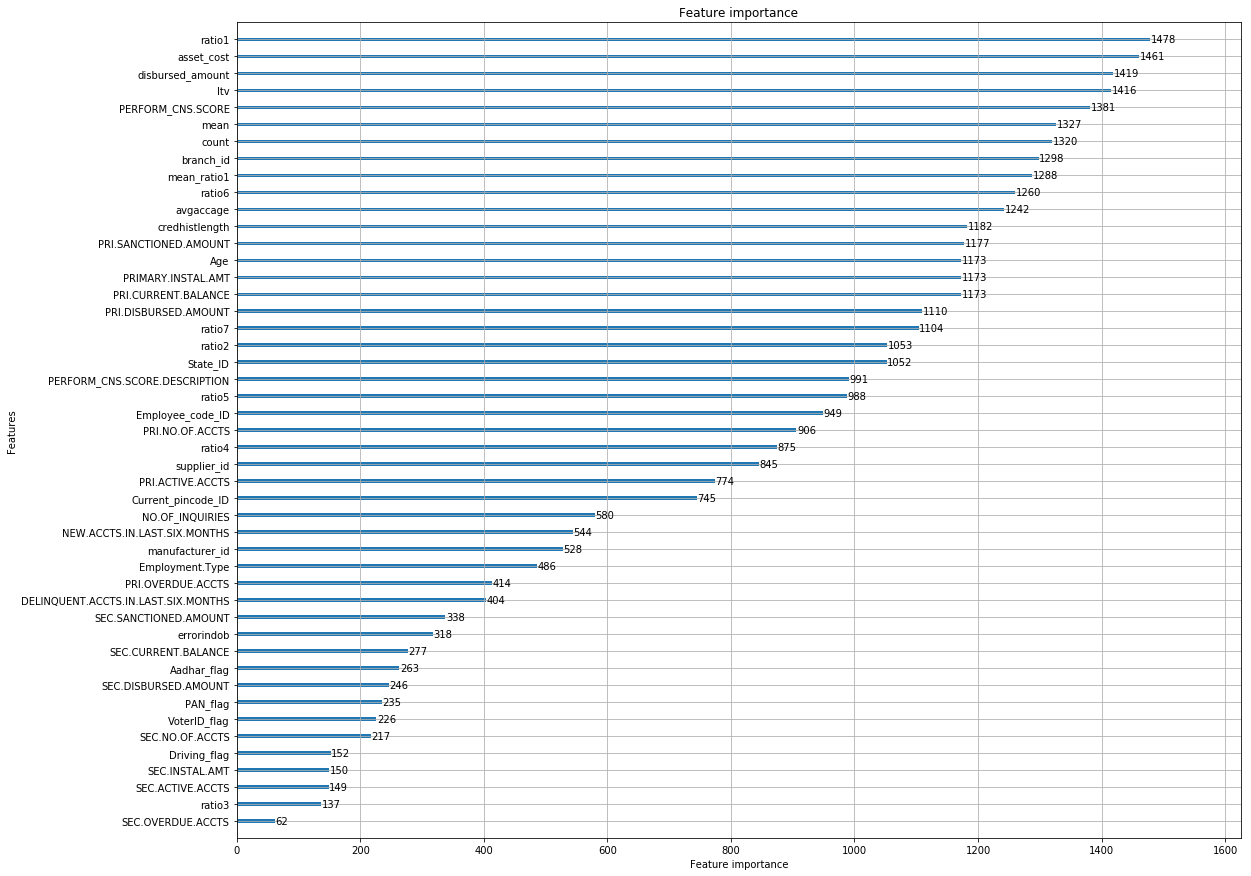

In [20]:
# feature importance
matplotlib.rcParams['figure.figsize'] = (18.0, 15.0)
lgb.plot_importance(model)

In [21]:
# test data reading n feature engineering
test=pd.read_csv('test_bqCt9Pv.csv')
test['Employment.Type']=test['Employment.Type'].fillna('nan')
test['Employment.Type']=lb.transform(test['Employment.Type'])
test['avgaccage']=test['AVERAGE.ACCT.AGE'].apply(clean_df)
test['credhistlength']=test['CREDIT.HISTORY.LENGTH'].apply(clean_df)
test['Date.of.Birth']=pd.to_datetime(test['Date.of.Birth'])
test['DisbursalDate']=pd.to_datetime(test['DisbursalDate'])
test['Age']=abs(test['DisbursalDate'].dt.year-test['Date.of.Birth'].dt.year)
test['ratio2']=test['PRI.DISBURSED.AMOUNT']/test['PRI.SANCTIONED.AMOUNT']
test['ratio3']=test['SEC.DISBURSED.AMOUNT']/test['SEC.SANCTIONED.AMOUNT']
test['sanctioned']=(test['ltv']/100)*test['asset_cost']
test['ratio1']=test['disbursed_amount']/test['sanctioned']
test['ratio4']=test['PRI.OVERDUE.ACCTS']/test['PRI.NO.OF.ACCTS']
test['ratio5']=test['PRI.ACTIVE.ACCTS']/test['PRI.NO.OF.ACCTS']
test['ratio6']=test['PRI.CURRENT.BALANCE']/test['PRI.DISBURSED.AMOUNT']
test['ratio7']=test['PRIMARY.INSTAL.AMT']/test['PRI.DISBURSED.AMOUNT']
test['dayofbirth']=test['Date.of.Birth'].dt.day
test['monthofbirth']=test['Date.of.Birth'].dt.month
errorindob1=[]
for i in range(test.shape[0]):
    if test['dayofbirth'][i]==1 and test['monthofbirth'][i]==1:
        errorindob1.append(1)
    else:
        errorindob1.append(0)
test['errorindob']=errorindob1
train['ratio1']=train['disbursed_amount']/train['sanctioned']
train['ratio2']=train['PRI.DISBURSED.AMOUNT']/train['PRI.SANCTIONED.AMOUNT']
train['ratio3']=train['SEC.DISBURSED.AMOUNT']/train['SEC.SANCTIONED.AMOUNT']
train['ratio4']=train['PRI.OVERDUE.ACCTS']/train['PRI.NO.OF.ACCTS']
train['ratio5']=train['PRI.ACTIVE.ACCTS']/train['PRI.NO.OF.ACCTS']
train['ratio6']=train['PRI.CURRENT.BALANCE']/train['PRI.DISBURSED.AMOUNT']
train['ratio7']=train['PRIMARY.INSTAL.AMT']/train['PRI.DISBURSED.AMOUNT']

In [22]:
# groupby features
merg=train.append(test)
dfff=merg.groupby(['Current_pincode_ID','State_ID'])['PERFORM_CNS.SCORE'].agg(['mean','count']).reset_index()
tess=test.merge(dfff,on=['Current_pincode_ID','State_ID'],how='left')
ltvff=merg.groupby(['Current_pincode_ID','State_ID'])['ratio1'].agg(['mean']).reset_index()
ltvff.columns=['Current_pincode_ID','State_ID','mean_ratio1']
tesss=tess.merge(ltvff,on=['Current_pincode_ID','State_ID'],how='left')

/home/Mahir/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [23]:
# ordinal encoding
tesss['PERFORM_CNS.SCORE.DESCRIPTION']=[mydict[x] for x in tesss['PERFORM_CNS.SCORE.DESCRIPTION']]

In [24]:
testt=tesss[['disbursed_amount', 'asset_cost', 'ltv','PERFORM_CNS.SCORE','Current_pincode_ID','State_ID','Aadhar_flag','MobileNo_Avl_Flag','PAN_flag','VoterID_flag','Driving_flag','PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS',
       'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE', 'PRI.SANCTIONED.AMOUNT',
       'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS', 'SEC.ACTIVE.ACCTS',
       'SEC.OVERDUE.ACCTS', 'SEC.CURRENT.BALANCE', 'SEC.SANCTIONED.AMOUNT',
       'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS','branch_id',
       'supplier_id', 'manufacturer_id','NO.OF_INQUIRIES','Employment.Type','Employee_code_ID','avgaccage','credhistlength','Age','ratio2','ratio3','ratio1','ratio4','ratio5','mean','count','PERFORM_CNS.SCORE.DESCRIPTION','ratio6','ratio7','mean_ratio1','errorindob']]

In [25]:
# take out ids
ids=tesss['UniqueID']

In [26]:
testt.shape

(112392, 48)

In [27]:
X.shape

(233154, 48)

In [28]:
test.shape

(112392, 54)

In [29]:
preds=model.predict(testt)

In [30]:
op=pd.DataFrame()
op['UniqueID']=ids
op['loan_default']=preds

In [31]:
op.to_csv('ltfs.csv',index=False)

In [32]:
# op